# Small data and deep learning
This pratical session proposes to study several techniques to improve training performance in the challenging context where few data and resources are available.

# Introduction
Assume we are in a context where few "gold" labeled data are available for training, say $\mathcal{X}_{\text{train}}\triangleq\{(x_n,y_n)\}_{n\leq N_{\text{train}}}$, where $N_{\text{train}}$ is small. A large test set $\mathcal{X}_{\text{test}}$ is available. A large amount of unlabeled data, $\mathcal{X}_{\text{nolabel}}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question :


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |


If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset.)

In your final report, please keep the logs of each training procedure you used. We will only run this jupyter if we have some doubts on your implementation. 

__The total file sizes should be reasonable (feasible with 2MB only!). You will be asked to hand in the notebook, together with any necessary files required to run it if any.__


To run your experiments, you can use the same local installation as for previous TPs, or otherwise https://colab.research.google.com/.

## Training set creation
__Question 1 (2 points) :__ Propose a dataloader that will only use the first 100 samples of the CIFAR-10 training set. 

*Hint* : You can modify the file located at https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py or use the information from https://pytorch.org/vision/stable/datasets.html

This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project. The remaining samples correspond to $\mathcal{X}_{\text{nolabel}}$. The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

In [ ]:
import os.path
import pickle
from typing import Any, Callable, Optional, Tuple

import numpy as np
from PIL import Image

from torchvision.datasets.utils import check_integrity, download_and_extract_archive
from torchvision.datasets.vision import VisionDataset

import torch
import torchvision
from torchvision.transforms import transforms as T 


import torch.nn as nn
import torch.nn.functional as F


import torch.optim as optim
import torch.backends.cudnn as cudnn

from collections import defaultdict

import torchvision.models as models



device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class CIFAR10(VisionDataset):
    """`CIFAR10 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.

    Args:
        root (string): Root directory of dataset where directory
            ``cifar-10-batches-py`` exists or will be saved to if download is set to True.
        train (bool, optional): If True, creates dataset from training set, otherwise
            creates from test set.
        transform (callable, optional): A function/transform that takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.

    """

    base_folder = "cifar-10-batches-py"
    url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    filename = "cifar-10-python.tar.gz"
    tgz_md5 = "c58f30108f718f92721af3b95e74349a"
    train_list = [
        ["data_batch_1", "c99cafc152244af753f735de768cd75f"],
        #["data_batch_2", "d4bba439e000b95fd0a9bffe97cbabec"], #A enlever
        #["data_batch_3", "54ebc095f3ab1f0389bbae665268c751"], #A enlever
        #["data_batch_4", "634d18415352ddfa80567beed471001a"], #A enlever
        #["data_batch_5", "482c414d41f54cd18b22e5b47cb7c3cb"], #A enlever
    ]

    test_list = [
        ["test_batch", "40351d587109b95175f43aff81a1287e"],
    ]
    meta = {
        "filename": "batches.meta",
        "key": "label_names",
        "md5": "5ff9c542aee3614f3951f8cda6e48888",
    }

    def __init__(
        self,
        root: str,
        train: bool = True,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        download: bool = False,
    ) -> None:

        super().__init__(root, transform=transform, target_transform=target_transform)

        self.train = train  # training set or test set

        if download:
            self.download()

        if not self._check_integrity():
            raise RuntimeError("Dataset not found or corrupted. You can use download=True to download it")

        if self.train:
            downloaded_list = self.train_list
        else:
            downloaded_list = self.test_list

        self.data: Any = []
        self.targets = []

        # now load the picked numpy arrays
        for file_name, checksum in downloaded_list:
            file_path = os.path.join(self.root, self.base_folder, file_name)
            with open(file_path, "rb") as f:
                entry = pickle.load(f, encoding="latin1")


############################the first 100 samples of the CIFAR-10 training set######
                if self.train:
                  end = 0
                  for sample in entry['data']:
                    self.data.append(sample)
                    end += 1
                    if end == 100:
                      break
                    
                  end = 0
                  for label in entry['labels']:
                    self.targets.append(label)
                    end += 1
                    if end == 100:
                      break


                else:
                  self.data.append(entry['data'])
                  self.targets.extend(entry['fine_labels'])

############################ END  #############################################


        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))  # convert to HWC

        self._load_meta()

    def _load_meta(self) -> None:
        path = os.path.join(self.root, self.base_folder, self.meta["filename"])
        if not check_integrity(path, self.meta["md5"]):
            raise RuntimeError("Dataset metadata file not found or corrupted. You can use download=True to download it")
        with open(path, "rb") as infile:
            data = pickle.load(infile, encoding="latin1")
            self.classes = data[self.meta["key"]]
        self.class_to_idx = {_class: i for i, _class in enumerate(self.classes)}

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self) -> int:
        return len(self.data)

    def _check_integrity(self) -> bool:
        root = self.root
        for fentry in self.train_list + self.test_list:
            filename, md5 = fentry[0], fentry[1]
            fpath = os.path.join(root, self.base_folder, filename)
            if not check_integrity(fpath, md5):
                return False
        return True

    def download(self) -> None:
        if self._check_integrity():
            print("Files already downloaded and verified")
            return
        download_and_extract_archive(self.url, self.root, filename=self.filename, md5=self.tgz_md5)

    def extra_repr(self) -> str:
        split = "Train" if self.train is True else "Test"
        return f"Split: {split}"



In [ ]:
transf = T.Compose([ T.ToTensor(),
                    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

X_train = CIFAR10(root='./', train=True, download=True, transform=transf)
trainloader = torch.utils.data.DataLoader(X_train, batch_size=10, shuffle=True, num_workers=2)

X_test = torchvision.datasets.CIFAR10(root='./', train=False, download=True, transform=transf)
testloader = torch.utils.data.DataLoader(X_test, batch_size=10, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
assert np.shape(X_train)==(100, 2) , 'X_train WRONG, revue it'
print('X_train good, continue')
assert np.shape(X_test)==(10000, 2) , 'X_test WRONG, revue it'
print('X_test good, continue')


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = asarray(a).shape
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


X_train good, continue
X_test good, continue


## Testing procedure
__Question 2 (1.5 points) :__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

Since the dataset is very small, especially compared to the number of features (100 samples of 32x32=1024 images), the model will not learn pertinent caracterestics of each class,during training, and will just overfit the dataset.
to adress this issue, several methods are applied, and we will implement them in the present Lab:

 

*   **Transfer learning**, where we import a pretrained model on another dataset and. we change it classification_layer, then we freez it (except the last added layer), then we train it on our dataset.

*   **Data Augmentation:**where we create artificial samples from the current samples. For instance, by applying geometric transformations in the case of images.

*   **Semi supervised learning:** where we combine a small labeled dataset with a large unlabled dataset in the training step.




# Raw approach: the baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performance with reported numbers from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate schedule, i.e. how to decrease the learning rate as a function of the number of epochs. A possible schedule is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the learning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper : http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. Obviously, it is a different context for those researchers who had access to GPUs.

## ResNet architectures

__Question 3 (4 points) :__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ResNet-18 model, originally designed for the ImageNet dataset, can be found here: https://arxiv.org/abs/1512.03385). Please report the accuracy obtained on the whole dataset as well as the reference paper/GitHub link.

*Hint:* You can re-use the following code: https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (\~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (\~5 minutes).

Code ResNet from scratch: source https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

In [ ]:
'''ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])



In [ ]:
resnet_scratch = ResNet18().to(device)


criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet_scratch.parameters(), 
                      lr=0.01,            # Learning rate 0.01
                      momentum=0.9, 
                      weight_decay=5e-4)

#scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)




In [ ]:

# Training step
def train(model, trainloader, criterion, optimizer):
  model.train()
  train_loss = 0
  correct = 0
  total = 0
  for batch_idx, (inputs, targets) in enumerate(trainloader):
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = outputs.max(1)
    total += targets.size(0)
    correct += predicted.eq(targets).sum().item()
  train_acc = correct/total
  return train_loss, train_acc

#testing step
def test(model, testloader, criterion):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    test_acc = correct/total
    return  test_acc

#our experiment
def run_experiment(epochs, model, trainloader, testloader, criterion, optimizer):
  history = defaultdict(list)
  for epoch in range(1,epochs+1):
    train_loss, train_acc = train(model, trainloader, criterion, optimizer)
    test_acc = test(model, testloader, criterion)

    #save logs for plots
    history['Train loss'].append(train_loss)
    history['Train Accuracy'].append(train_acc)
    history['Test Accuracy'].append(test_acc)

    print(" \nEpoch {}/{} :    train_loss {:.3f};     train_accuracy {:.2%}       Test_accuracy {:.2%}"
    .format(epoch, epochs, train_loss, train_acc, test_acc))
    #print(" \nEpoch {}/{} :    train_loss {:.3f};     train_accuracy {:.2%}       "
    #.format(epoch, epochs, train_loss, train_acc))

  return history



In [ ]:
history_resnet_scratch = run_experiment(20, resnet_scratch, trainloader, testloader, criterion, optimizer)

 
Epoch 1/20 :    train_loss 24.671;     train_accuracy 19.00%       Test_accuracy 10.61%
 
Epoch 2/20 :    train_loss 28.837;     train_accuracy 24.00%       Test_accuracy 14.18%
 
Epoch 3/20 :    train_loss 24.737;     train_accuracy 25.00%       Test_accuracy 12.03%
 
Epoch 4/20 :    train_loss 24.272;     train_accuracy 30.00%       Test_accuracy 17.29%
 
Epoch 5/20 :    train_loss 15.806;     train_accuracy 46.00%       Test_accuracy 17.84%
 
Epoch 6/20 :    train_loss 14.132;     train_accuracy 55.00%       Test_accuracy 15.97%
 
Epoch 7/20 :    train_loss 13.707;     train_accuracy 50.00%       Test_accuracy 16.92%
 
Epoch 8/20 :    train_loss 8.734;     train_accuracy 72.00%       Test_accuracy 20.01%
 
Epoch 9/20 :    train_loss 8.334;     train_accuracy 78.00%       Test_accuracy 19.29%
 
Epoch 10/20 :    train_loss 12.020;     train_accuracy 67.00%       Test_accuracy 11.95%
 
Epoch 11/20 :    train_loss 9.987;     train_accuracy 69.00%       Test_accuracy 20.94%
 
Epoch 12/


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet-18  | 20 | 97.00% | 21.32% |


# Transfer learning

We propose to use pre-trained models on a classification task, in order to improve the results of our setting.

## ImageNet features

Now, we will use a model pre-trained on ImageNet and see how well it performs on CIFAR. A list of ImageNet pre-trained models is available on : https://pytorch.org/vision/stable/models.html

__Question 4 (3 points) :__ Pick a model from the list above, adapt it for CIFAR and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

See the results below, we manage a bit over 50% by retraining the last layer only.

In [ ]:

#import pretrained resnet18
resnet_18 = models.resnet18(pretrained=True)
resnet_18 = resnet_18.to(device)

#transformations for resnet pretrained
normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
transform = T.Compose([T.Resize(224), T.ToTensor(), normalize])

#Data loaders

X_train_res = CIFAR10(root='./', train=True, download=True, transform=transform)
trainloader_res = torch.utils.data.DataLoader(X_train_res, batch_size=10, shuffle=True, num_workers=2)

X_test_res = torchvision.datasets.CIFAR10(root='./', train=False, download=True, transform=transform)
testloader_res = torch.utils.data.DataLoader(X_test_res, batch_size=10, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
#print(resnet_18)

In [ ]:
#Defining our top layer classifier

class our_classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1=nn.Linear(512,256)
        self.linear2=nn.Linear(256,10)
    
    def forward(self,x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x


classifier = our_classifier().to(device)

#replace top layer of resnet18
resnet_18.fc = classifier

#freeze all the network
for param in resnet_18.parameters():
        param.requires_grad = False

#unfreeze only the classifier
for param in resnet_18.fc.parameters():
        param.requires_grad = True


In [ ]:
#resnet_18.fc

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_18.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


In [ ]:
history_resnet18 = run_experiment(20, resnet_18, trainloader_res, testloader_res, criterion, optimizer)

 
Epoch 1/20 :    train_loss 23.457;     train_accuracy 16.00%       Test_accuracy 19.47%
 
Epoch 2/20 :    train_loss 19.958;     train_accuracy 30.00%       Test_accuracy 29.06%
 
Epoch 3/20 :    train_loss 16.911;     train_accuracy 43.00%       Test_accuracy 41.92%
 
Epoch 4/20 :    train_loss 13.766;     train_accuracy 66.00%       Test_accuracy 45.06%
 
Epoch 5/20 :    train_loss 12.204;     train_accuracy 77.00%       Test_accuracy 46.03%
 
Epoch 6/20 :    train_loss 11.000;     train_accuracy 69.00%       Test_accuracy 46.20%
 
Epoch 7/20 :    train_loss 8.793;     train_accuracy 85.00%       Test_accuracy 53.85%
 
Epoch 8/20 :    train_loss 7.341;     train_accuracy 86.00%       Test_accuracy 48.83%
 
Epoch 9/20 :    train_loss 6.305;     train_accuracy 88.00%       Test_accuracy 51.15%
 
Epoch 10/20 :    train_loss 6.256;     train_accuracy 87.00%       Test_accuracy 51.47%
 
Epoch 11/20 :    train_loss 4.388;     train_accuracy 90.00%       Test_accuracy 50.26%
 
Epoch 12/20


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet-18  | 20 | 98.00% | 51.48% |

# Incorporating priors
Geometrical priors are appealing for image classification tasks. 
A color image $x$ can be seen as a function: $\mathbb{S}\rightarrow\mathbb{R}^3$, where $\mathbb{S} \subset \mathbb{R}^2$ is the image support.
Let us consider transformations $\mathcal{T}$ of possible inputs $x$. For instance, if an image had infinite support, a translation $\mathcal{T}_a$ of an image $x$ by a shift $a$ would lead to a new infinite-support image $\mathcal{T}_a(x)$, described at each pixel $u$ by :

$$\forall u, \mathcal{T}_a(x)(u)=x(u-a)\,.$$

__Question 5 (1.5 points) :__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

There are the traditional issues when dealing with geometric transformation, such as with what color we fill the void created by the transformation (since it does not have infinite support). 

Furthermore, a transformation is very likely to move a pixel in between grid of pixels (an image is not continuous), and so we have to decide what the new color is (we could use nearest, bilinear, bicubic,Lanczos,..). 

However, with such a small scale (the 32 by 32), the problem is accentuated. To avoid this problem, it is ia good idea to use stronger resampling methods (such as a bilinear or bicubic filter instead of nearest neighbor). 

Lastly, CNNs tend to use strides in their architectures. 

This may make them a less invariant to translations and other transformations especially on small images.

## Data augmentations

__Question 6 (3 points) :__ Propose a set of geometric transformations beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ with them and report the accuracies.
You can use tools from https://pytorch.org/vision/stable/transforms.html 

In [ ]:
# several techniques for data augmentations
train_aug2_transforms =  T.Compose([
                             T.RandomCrop((26,26)),
                             T.RandomHorizontalFlip(),
                             T.RandomAffine(degrees=15, translate=(0.2, 0.2), scale=(0.8,1.2), shear=(-3,3,-3,3),  interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
                             T.ToTensor(),
                             T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  ,
                             ])

test_transforms = T.Compose([
                                T.ToTensor(),
                                T.Normalize([0.5, 0.5, 0.5],
                                [0.5, 0.5, 0.5])])



X_train_aug2 = CIFAR10(root='./', train=True, download=True, transform=train_aug2_transforms)
trainloader_aug2 = torch.utils.data.DataLoader(X_train_aug2, batch_size=10, shuffle=True, num_workers=2)

X_test_aug = torchvision.datasets.CIFAR10(root='./', train=False, download=True, transform=test_transforms)
testloader_aug2 = torch.utils.data.DataLoader(X_test_aug, batch_size=10, shuffle=False, num_workers=2)

new_resnet_2 = ResNet18().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(new_resnet_2.parameters(), 
                      lr=0.01,            # Learning rate 0.01
                      momentum=0.9, 
                      weight_decay=5e-4)

#scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)
history_newresnet_2 = run_experiment(100, new_resnet_2, trainloader_aug2, testloader_aug2, criterion, optimizer)

Files already downloaded and verified
Files already downloaded and verified
 
Epoch 1/100 :    train_loss 29.357;     train_accuracy 12.00%       Test_accuracy 9.70%
 
Epoch 2/100 :    train_loss 30.262;     train_accuracy 18.00%       Test_accuracy 9.75%
 
Epoch 3/100 :    train_loss 28.122;     train_accuracy 16.00%       Test_accuracy 10.89%
 
Epoch 4/100 :    train_loss 26.686;     train_accuracy 14.00%       Test_accuracy 17.15%
 
Epoch 5/100 :    train_loss 25.274;     train_accuracy 12.00%       Test_accuracy 17.66%
 
Epoch 6/100 :    train_loss 25.144;     train_accuracy 19.00%       Test_accuracy 17.60%
 
Epoch 7/100 :    train_loss 22.568;     train_accuracy 16.00%       Test_accuracy 18.02%
 
Epoch 8/100 :    train_loss 20.588;     train_accuracy 25.00%       Test_accuracy 21.25%
 
Epoch 9/100 :    train_loss 21.420;     train_accuracy 20.00%       Test_accuracy 17.07%
 
Epoch 10/100 :    train_loss 22.345;     train_accuracy 26.00%       Test_accuracy 17.56%
 
Epoch 11/100 


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet-18  | 100 | 71.00% | 24.58% |

# Conclusions

__Question 7 (5 points) :__ Write a short report explaining the pros and the cons of each method you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

In this Lab, we tackle the problem of training on small datasets.
The first task was to train a model in a small training set, then to test it's performance on a larger testing set. The performance of this task was really bad due to overfitting.

To adress this issue, we used two different methods, transfer learning and data augmentation. 

**Method 1: Transfer Learning**

This method consists of using a pretrained model, adapting it's classification layer to our task, then training just few lyaers on the new dataset (while freezing the others).

*Pros:*
    
Rapidity and good performance: The implementation showed very good results very quickly and so is easily a go to method, whenever we have a low amount of samples. 
    
*Cons:*

A clear downside to this method is that it requires a model that was trained on a similar task to ours, and that is available to us, which for many real world application is not the case. 
    
By only relearning the last layer, we can obtain a test score a bit over 50%. The baseline from the paper is at 45% with 100 training sample on Cifar10, which is lower than our results. However this could be explained by the small sample size, which means that they may have gotten a worst set of images than ours. 

**Method 2: Data augmentation**

The main idea of this method is to apply random transformations to the images throughout the training phase. This forces the model to learn a more complex underlying distribution for the classes. 

*Pros:*

This method is great as it allows the model to perform better for "free", as it can be applied anytime. 

*Cons:*

However, it requires at least a bit of tunning to get it right, and the effect are there but essentially limited. We manage to get above 24% after some tunning of the transformations, and training for much longer, since this time the model did not overfit the training set very quickly.

In [ ]:

import matplotlib.pyplot as plt

def plot_fig(history):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  xs = np.arange(1, len(history['Train Accuracy']) + 1)
  ax.plot(xs, history['Train Accuracy'], '.-', label='Train')
  ax.plot(xs, history['Test Accuracy'], '.-', label='Test')
  ax.set_xlabel('epoch')
  ax.set_ylabel('Accuracy')
  ax.legend()
  ax.grid()
  plt.show()


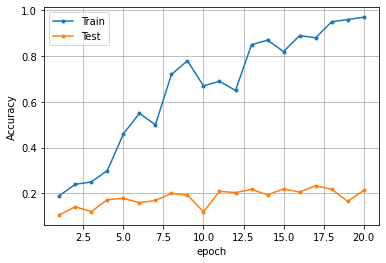

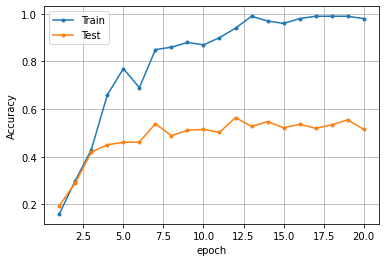

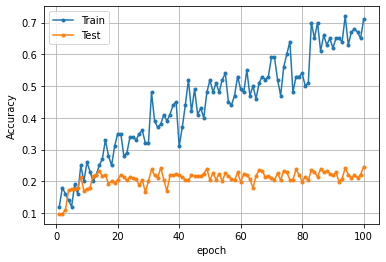

In [ ]:
history_experiments = [history_resnet_scratch, history_resnet18, history_newresnet_2]
for history in history_experiments:
  plot_fig(history)

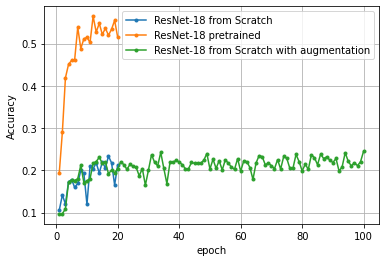

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
xs = np.arange(1, len(history_resnet_scratch['Test Accuracy']) + 1)
ax.plot(xs, history_resnet_scratch['Test Accuracy'], '.-', label='ResNet-18 from Scratch')
xs = np.arange(1, len(history_resnet18['Test Accuracy']) + 1)
ax.plot(xs, history_resnet18['Test Accuracy'], '.-', label='ResNet-18 pretrained')
xs = np.arange(1, len(history_newresnet_2['Test Accuracy']) + 1)
ax.plot(xs, history_newresnet_2['Test Accuracy'], '.-', label='ResNet-18 from Scratch with augmentation')
ax.set_xlabel('epoch')
ax.set_ylabel('Accuracy')
ax.legend()
ax.grid()
plt.show()

# Weak supervision

__Bonus \[open\] question (up to 4 points) :__ Pick a weakly supervised method that will potentially use $\mathcal{X}_{\text{nolabel}}\cup\mathcal{X}_{\text{train}}$ to train a model (a subset of $\mathcal{X}_{\text{nolabel}}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.